# Explore The Data

Gather the troops

In [75]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import source.funk as fun

sns.set_palette('Set2')  # look at those beautiful colours

import warnings
warnings.filterwarnings('ignore')

Load the Data

In [2]:
df = pd.read_csv('data/Test Report 2017-2018.csv')

Have a look at the size of that thing

In [3]:
df.shape

(1061, 11)

Those are the features

In [4]:
df.columns

Index(['Account Name', 'Contact: Title', 'Lead Source', 'Industry',
       'Mailing City', 'Mailing State/Province', 'Mailing Country', 'Amount',
       'Close Date', 'Created Date', 'Won'],
      dtype='object')

In [5]:
df.head(1)

,Account Name,Contact: Title,Lead Source,Industry,Mailing City,Mailing State/Province,Mailing Country,Amount,Close Date,Created Date,Won
0,Name 430,NaN,Existing Customer,Chemicals,NaN,NaN,NaN,"$18,000.00",11/5/2018,10/17/2018,1.0


Data types and null values:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1061 entries, 0 to 1060
Data columns (total 11 columns):
Account Name              1061 non-null object
Contact: Title            896 non-null object
Lead Source               1056 non-null object
Industry                  959 non-null object
Mailing City              403 non-null object
Mailing State/Province    397 non-null object
Mailing Country           367 non-null object
Amount                    990 non-null object
Close Date                1056 non-null object
Created Date              1056 non-null object
Won                       1056 non-null float64
dtypes: float64(1), object(10)
memory usage: 91.3+ KB


- Every single feature except for Account Name presents null-values
- Only 40% of location information such as Country, State/Prob, City are not-null
- The single feature which provides a solid data type is Won, which is also the target.

## EDA & FEATURE ENGINEERING

### Target: Won

In [7]:
df['Won'] = df.Won.fillna(-1) # Nan values within my target? Not my tempo.

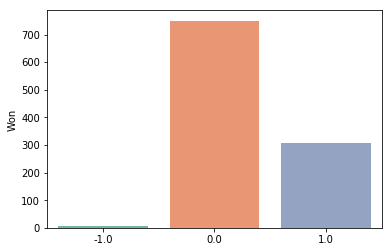

In [8]:
counts = df['Won'].value_counts()
sns.barplot(counts.index, counts);

In [9]:
df.Won.value_counts()

 0.0    750
 1.0    306
-1.0      5
Name: Won, dtype: int64

- We have 5 null values within the target which I will get rid of due to insignificant amount.

In [10]:
df.drop(df[df.Won == -1].index, inplace=True)

Winner customers(Won = 1): 29.0%
Other customers (Won = 0): 71.0%
Number of (Won = 1): 306
Number of  (Won = 0): 750


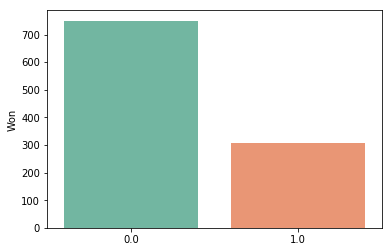

In [11]:
fun.seaborn_count_barplot_won(df,'Won')

29% VS 71% - pretty balanced if you ask me.

Metrics

In [12]:
df.describe() 

,Won
count,1056.000000
mean,0.289773
std,0.453872
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


### Feature: Account Name

Are there any duplicate account names?

In [13]:
df['Account Name'].value_counts().unique() 

array([8, 7, 5, 4, 3, 2, 1])

Looks like there are. Let's have a look at their distribution. 

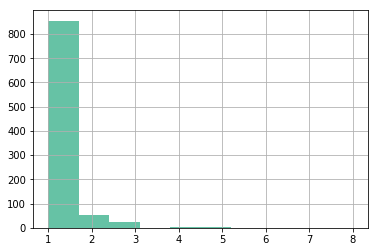

In [14]:
df['Account Name'].value_counts().hist()

Number of account names that are not unique:

In [15]:
len(df['Account Name']) - len(df['Account Name'].unique())

122

Number of unique account names

In [16]:
len(df['Account Name'].unique())

934

We have 122 diplicate account names. How about complete duplicate rows? 

In [17]:
df["is_duplicate"]= df.duplicated()
print(df.is_duplicate.sum())
df.drop(['is_duplicate'],axis=1,inplace = True)

0


Shall I drop these duplicate account names?

I am not well informed about the business case here. Thereby I will have a close look before I drop these.

df.duplicate_account_name = df['Account Name'].duplicated()
df_dubs = df[df.duplicate_account_name == True]
fun.seaborn_count_barplot_won(df_dubs,'Won')

Including only duplicate account names in the analisis shows that the win rate(Lets call it WR from now on) is consiredably higher compared to overal WR(29%).

My thoughts about non-unique account names are based on the analysis. However, the issue with the duplicate account names shall be investigated. 

My questions are: 

- Is the organization records this piece data properly? 
- Are their customers (or users depending on the business case) allowed to enrol multiple times? 

The company shall take action depending on the answers to these questions.

### Feature: "Contact: Title"

Python perceives the datatype of the column as an object because of the null values.

Change that:

In [18]:
df = df.fillna(-1)
df['Contact: Title'] = df['Contact: Title'].astype(str)

Have a look at the number of unique values and unique values themselves.

In [19]:
len(df['Contact: Title'].unique()) # This will hurt.

411

411 unique values within a categorical feature where the total number of datapoints is only 1100. 

How can I get something useful out of this feature?

In [20]:
df['Contact: Title'].unique()[0:20]  #

array(['-1', 'President', 'VP of Consulting Services',
       'Operations and HR Manager', 'Business Development',
       'Vice President of Human Resources', 'COO',
       'Director of Hotel Sales', 'Director of HR', 'Owner', 'SVP', 'CEO',
       'Executive Managing Director', 'Regional Sales Manager',
       'Talent Acquisition Manager', 'Director of Strategic Partnerships',
       'HR Manager', 'Head of HR', 'Sales Manager', 'ceo'], dtype=object)

Certainly there are more than one unique way to write "CEO".

"CEO = ceo = Chief Executive Officer" However machines don't know that if you don't teach it.

In other words, I will cluster similar values in order to create a new and less fragmented features from "Contact Title".

**New Feature: Rank(generated from Title)**

fun.title_ranks: clusters titles under leadership ranks.

example:

- owners, CEOs' etc. : rank 1
- VP : rank 2
- office manager : rank 4

In [21]:
df['rank'] = df['Contact: Title'].map(fun.title_ranks)

In [22]:
df['rank'].value_counts()

rank_1          350
rank_2          297
rank_unknown    160
rank_3          159
rank_4           90
Name: rank, dtype: int64

Count_barplot

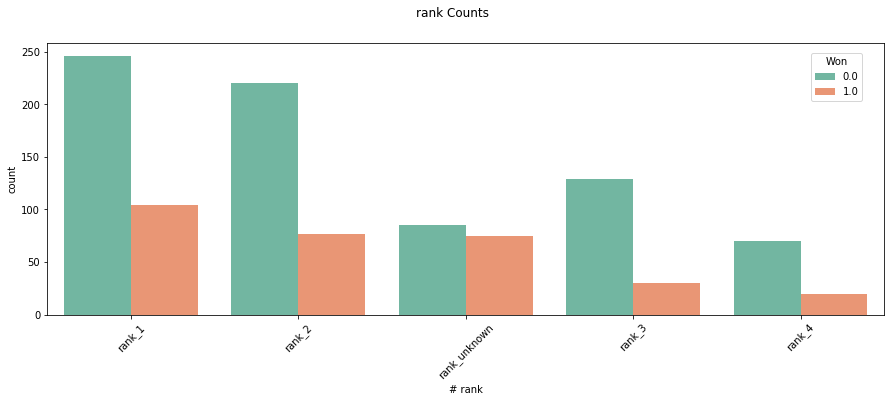

In [23]:
fun.barplot_vs(df,'rank','Won')

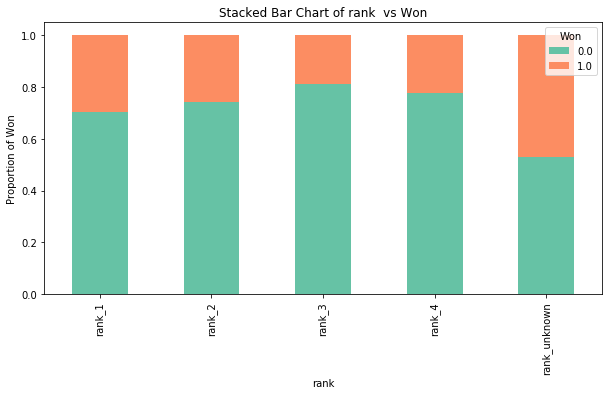

In [24]:
fun.stacked_bar_chart(df,'rank','Won')

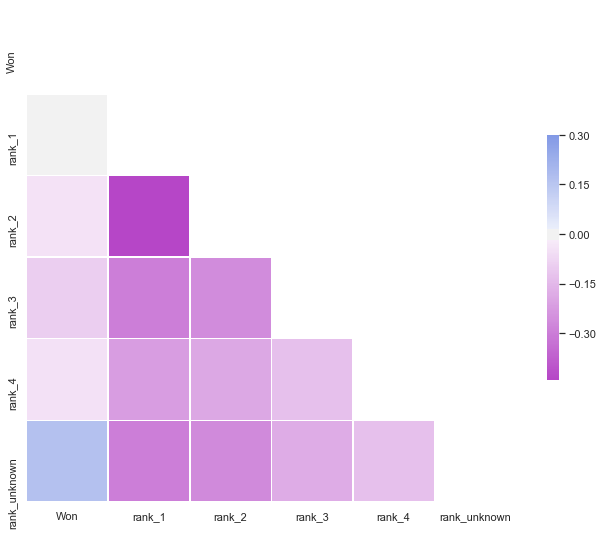

In [25]:
fun.heatmap(df,['rank'])


In accordance to graph Customer Ranking Counts:

- The majority of the users are C-level or owners
- rank_unknown, stands for null values and numbered about 150. 
- Again rank_unknown stands for the highest Winrate.
- There is an exponential distribution from rank_1 to rank_4

**New Feature: job_category**

This time I grouped the Titles based on the field of profession.


In [26]:
df['job_category'] = df['Contact: Title'].map(fun.title_job_category)

In [27]:
df['job_category'].value_counts()  
#Looks better compared to 400+ different jobs eh?

HR            262
Owner_Ceo     250
S & M         160
n/a           160
Manager        51
OPS            42
Other          35
BD             22
Finance        18
Culture        13
Office         13
Consulting     10
Project         7
Product         5
CLS             5
Tech            3
Name: job_category, dtype: int64

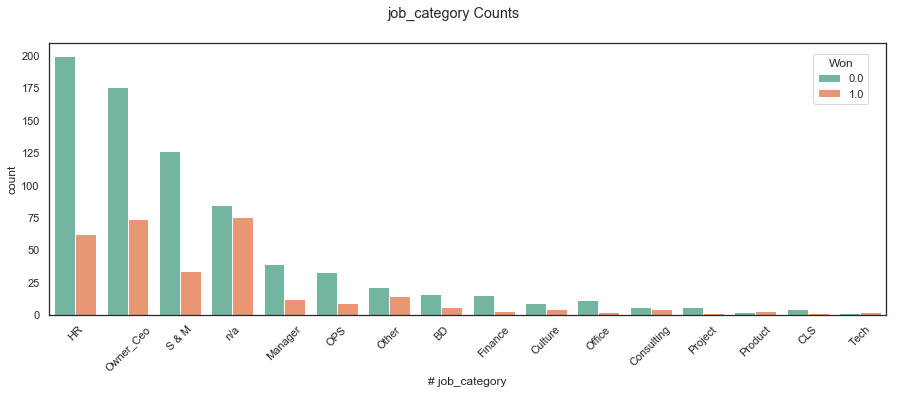

In [28]:
fun.barplot_vs(df,'job_category','Won')

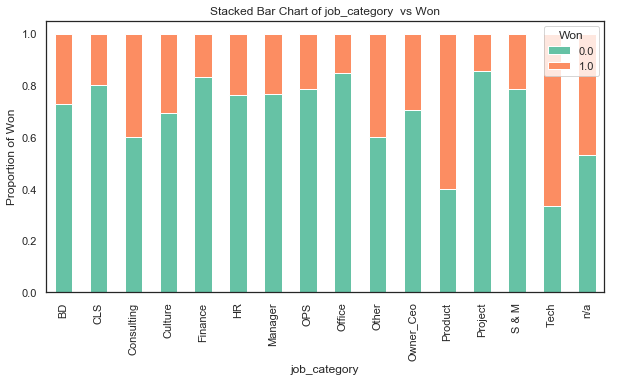

In [29]:
fun.stacked_bar_chart(df,'job_category','Won')

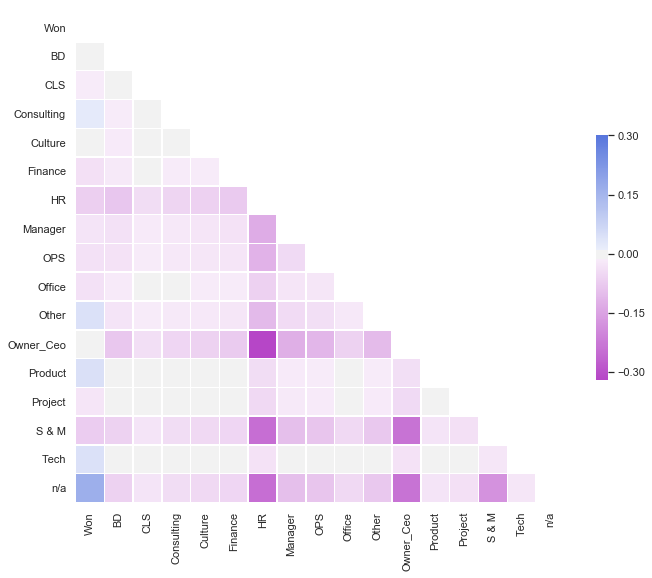

In [32]:
fun.heatmap(df,['job_category'])

- The win rate is dominant only for tech, product and n/a professionals.
- I want to highlight that the number of tech and product people is not significant within the dataset. Therefore their higher win rate is just a result of the fact that they are outliers. Increasing their numbers within the dataset would lead to a similar distribution with those of other job fields.

## Feature: Lead Source

In [33]:
df['Lead Source'].unique()  

array(['Existing Customer', 'MKTG Call-in', 'Sales - Partner',
       'MKTG - Web (Contact Form)', 'Google Ad', 'Google Natural Search',
       'Referral- Network', 'Delivery', 'MKTG Email - @Peak',
       'MKTG Adv - Linkedin', 'MKTG Trade Show', 'Referral-Customer',
       'MKTG Adv - Google Adwords', 'Bing Natural Search', 'LinkedIn',
       'BuiltinChicago', 'Sales', 'Bing PPC', 'MKTG Referral - Partner',
       'MKTG Adv - Google Adwords - Call-in', 'MKTG - Web (Chatbot)',
       'MKTG LinkedIn Outreach', 'Ask.com Natural Search',
       'MKTG Word of mouth', 'MKTG Adv - BING', 'Yahoo! Natural Search',
       'Referral-Employee', 'MKTG Email - Back to Base V2',
       'Referral-Other', 'MKTG Public Relations'], dtype=object)

Another Fragmented feature. This time the fragmentation is due to high number of subcategories. 

In [34]:
df['Lead Source'].value_counts()

Google Natural Search                  245
MKTG Call-in                           223
MKTG - Web (Contact Form)              206
Existing Customer                      137
MKTG Adv - Google Adwords               74
MKTG Referral - Partner                 24
Google Ad                               20
MKTG Email - @Peak                      17
Bing Natural Search                     17
MKTG Adv - Linkedin                     14
Referral- Network                       12
Sales                                   12
Delivery                                10
MKTG Adv - Google Adwords - Call-in     10
Referral-Customer                        6
MKTG Adv - BING                          6
MKTG - Web (Chatbot)                     3
LinkedIn                                 2
Sales - Partner                          2
Bing PPC                                 2
Referral-Other                           2
Yahoo! Natural Search                    2
MKTG Word of mouth                       2
Referral-Em

Group them:

In [35]:
df['lead_group'] = df['Lead Source'].map(fun.lead_group_donut)

In [36]:
df.lead_group.value_counts()

 MKTG                583
Google               265
Existing Customer    137
Other                 49
Referral              22
Name: lead_group, dtype: int64

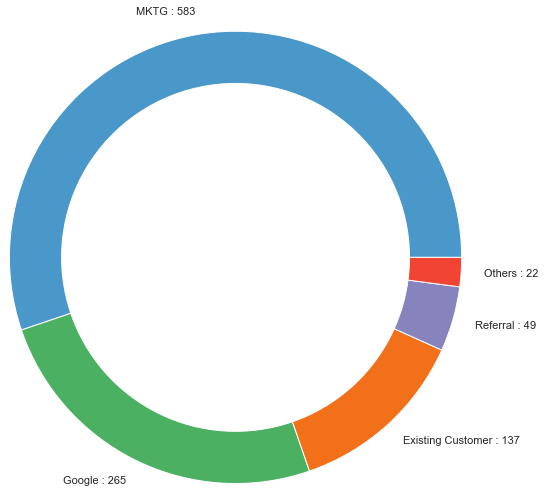

In [37]:
fun.outter_donut(df,fun.group_size(df)[0],fun.group_size(df)[1])

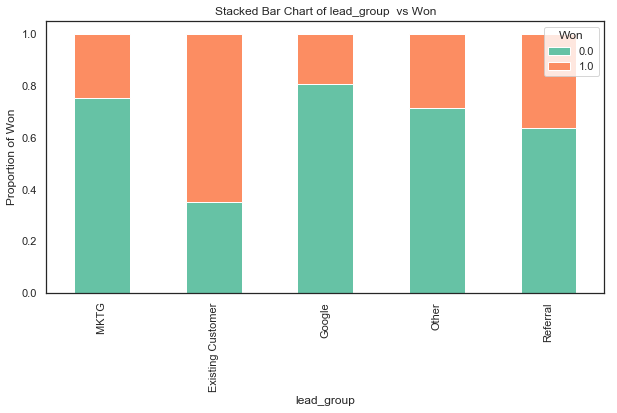

In [38]:
fun.stacked_bar_chart(df,'lead_group','Won')

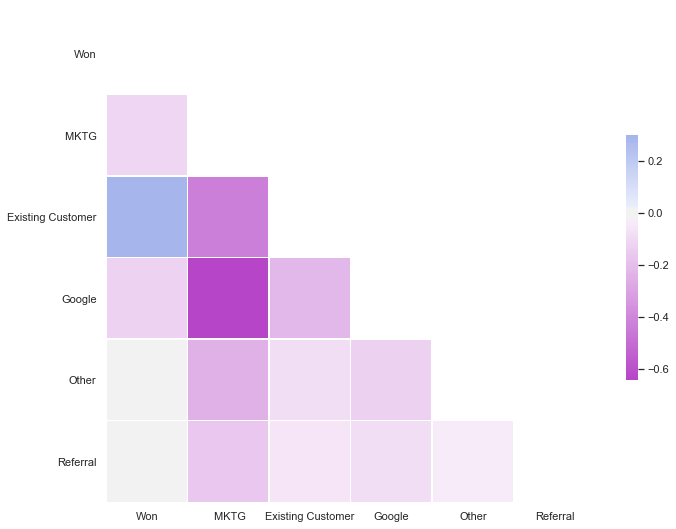

In [39]:
fun.heatmap(df,['lead_group'])

~ 65% of existing customers end up with Won == 1 which is significantly higher compared to not only other lead_source groups but also overal average.
- Ultimatelly, trust is a thing. Who would guess that?

** Sub category : Lead Source**

In [40]:
def find_mktg(x):
    if 'MKTG' in x:
        return x
    else:
        return 0

df['mktg'] = df['Lead Source'].map(find_mktg)
df_mktg = df[df.mktg != 0]

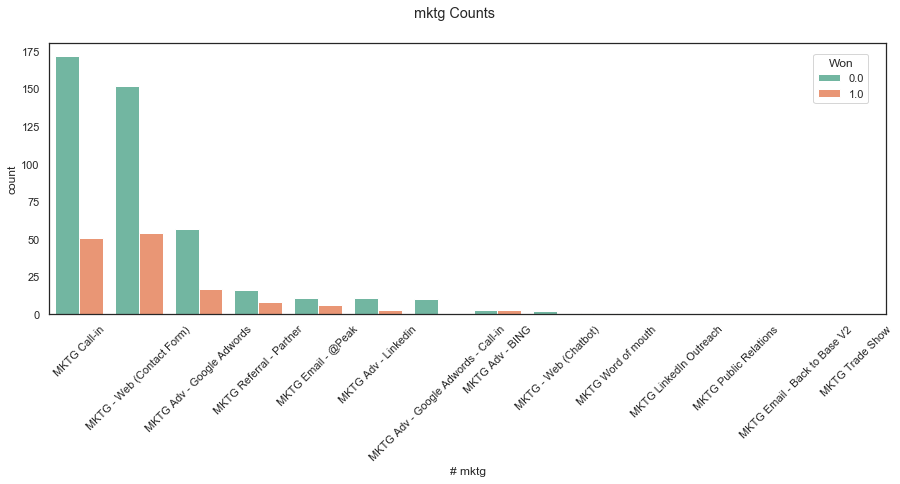

In [41]:
fun.barplot_vs(df_mktg,'mktg','Won')

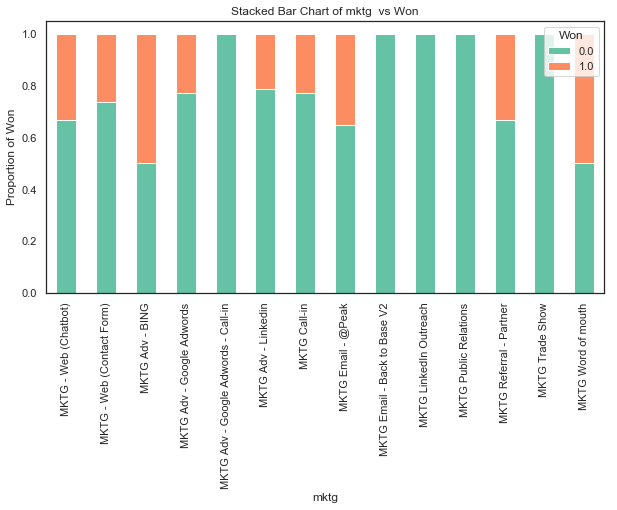

In [42]:
fun.stacked_bar_chart(df_mktg,'mktg','Won')  #remember most of the following subcategories are very low in numbers.

**Sub Category of Lead Source: Google**

In [43]:
def find_google(x):
    if 'Google' in x:
        return x
    else:
        return 0

df['google'] = df['Lead Source'].map(find_google)
df_google = df[df.google != 0]

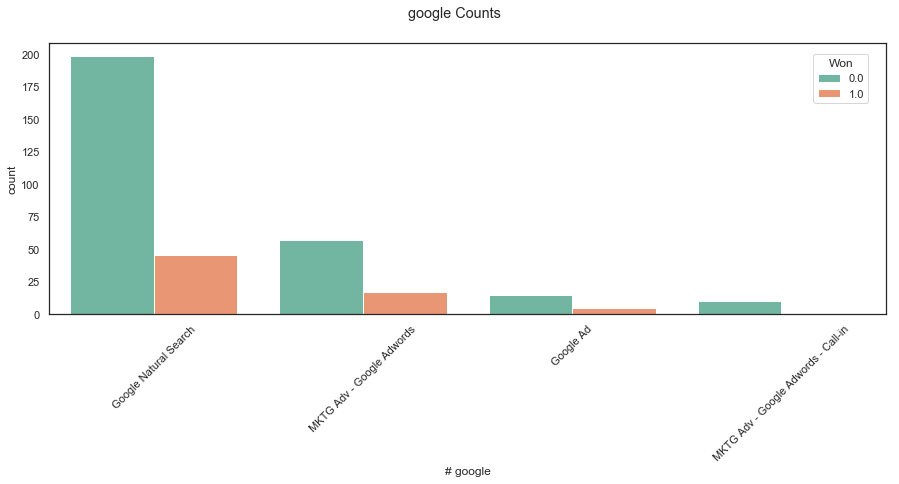

In [44]:
fun.barplot_vs(df_google,'google','Won')

- Natural search engine brings in a lot of leads and Adv contributes by ~ 1/3 of the natural search engine.

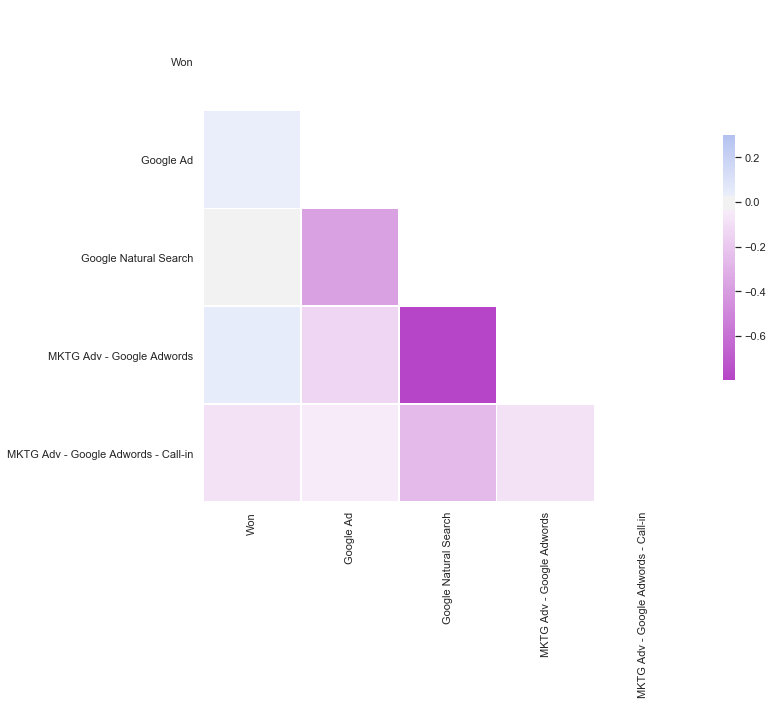

In [45]:
fun.heatmap(df_google,['google'])

### Feature: Industry

In [46]:
len(df.Industry.unique())

96

In [47]:
df['Industry'].value_counts()[0:15] #honestly... does this have an end?

Computer Software                      135
Information Technology and Services    111
-1                                      97
Manufacturing                           69
Consulting                              62
Retail                                  51
Other                                   42
Finance                                 35
Technology                              29
Construction                            26
Financial services                      24
Telecommunications                      23
Machinery                               19
Internet                                15
Marketing and Advertising               14
Name: Industry, dtype: int64

In [48]:
df = fun.industry_group(df,'Industry')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a12146e10>],
      dtype=object)

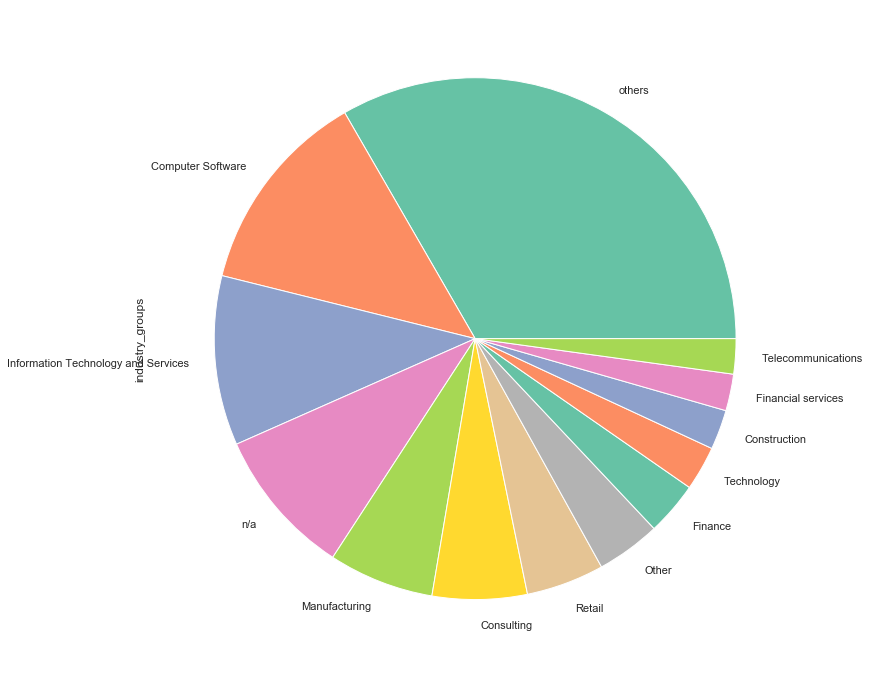

In [49]:
# df['industry_groups'] = df['industry_groups'].astype(str)
df['industry_groups'] = df['industry_groups'].astype(str)
df['industry_groups'].value_counts().plot(kind='pie', subplots=True, figsize=(12, 12))

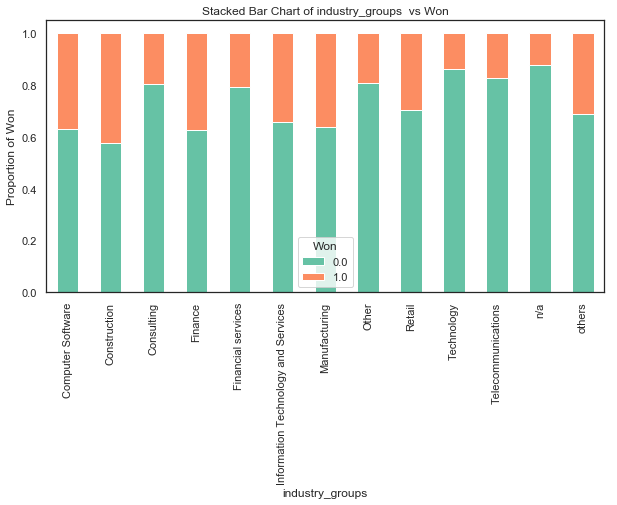

In [50]:
fun.stacked_bar_chart(df,'industry_groups','Won')  #remember most of the following subcategories are very low in numbers.

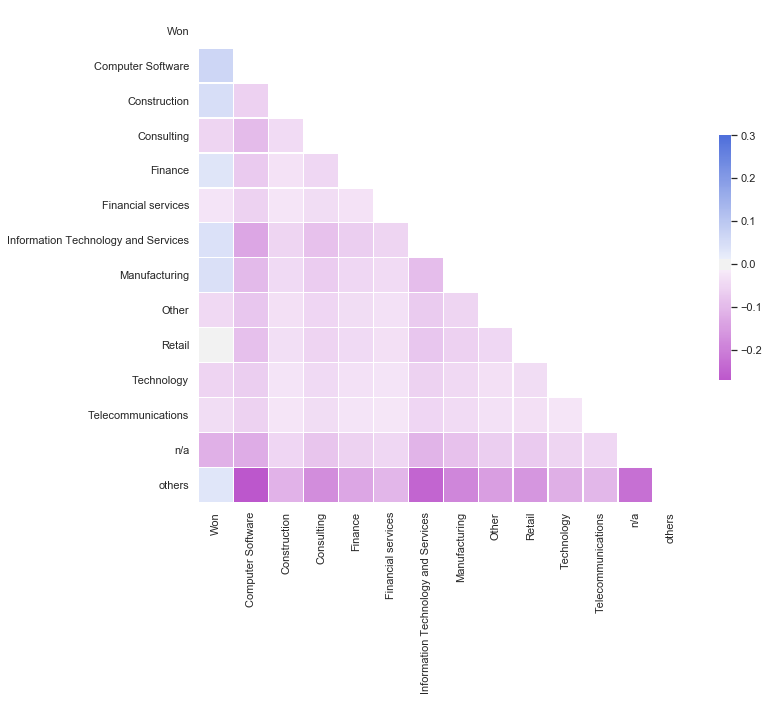

In [51]:
df_heat_map_industry_groups = df[['Won','industry_groups']]
fun.heatmap(df_heat_map_industry_groups,['industry_groups'])

### Features: Location: 'Mailing City','Mailing State/Province','Mailing Country'

In [52]:
df_location = pd.read_csv('data/Test Report 2017-2018.csv')
df_location = df_location[['Won','Mailing City','Mailing State/Province','Mailing Country']]

In [53]:
df_location.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1061 entries, 0 to 1060
Data columns (total 4 columns):
Won                       1056 non-null float64
Mailing City              403 non-null object
Mailing State/Province    397 non-null object
Mailing Country           367 non-null object
dtypes: float64(1), object(3)
memory usage: 33.2+ KB


Location data consists of high numbers of null values.

In [54]:
df_location.fillna(-1,inplace=True)
df_location = df_location[df_location['Won']!=-1]

In [55]:
df_location['Mailing City'].value_counts()[0:15]

-1               653
New York          15
Toronto           14
London            14
San Francisco     10
Mississauga       10
Boston             7
Ottawa             7
Chicago            5
Raleigh            4
Montreal           4
Brooklyn           4
Richmond           4
Dallas             3
Pittsburgh         3
Name: Mailing City, dtype: int64

No,this one is incredibly fragmented. Im not doing that.

In [56]:
df['Mailing State/Province'].value_counts()[0:15]

-1               659
CA                35
ON                27
Ontario           25
California        20
NY                15
Florida           15
New York          14
MA                13
IL                10
Massachusetts     10
PA                 9
TX                 9
BC                 7
Illinois           7
Name: Mailing State/Province, dtype: int64

- CA on one hand California at the other hand.
- Have some potential, this one due to less fragmented data(Yoda is alive).

As I am getting a little bored here, let me demonstrate you my incredible tableau visil skills. 

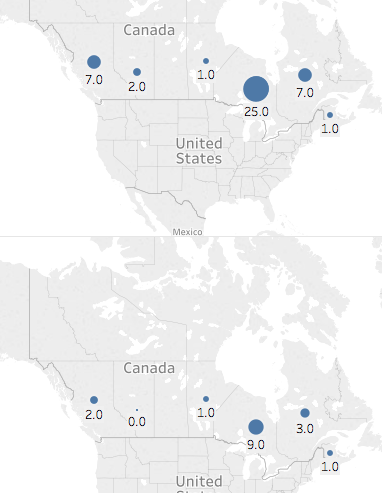

In [57]:
from IPython.display import Image
Image("Tablo/pic1.png") 
#tableau public visuals, yeah yeah I know haters gona hate. 
#yeah btw thats how you can Include screenshots on your ipython notebook.

When it comes to Canadian provinces, Ontario seem to be the most dominant one in terms of enrollments and winners.

In [58]:
df_location['Mailing Country'].value_counts()[0:10]

-1                          689
United States               151
Canada                       64
US                           61
USA                          22
United States of America     19
United Kingdom               11
England                       9
UK                            4
Australia                     4
Name: Mailing Country, dtype: int64

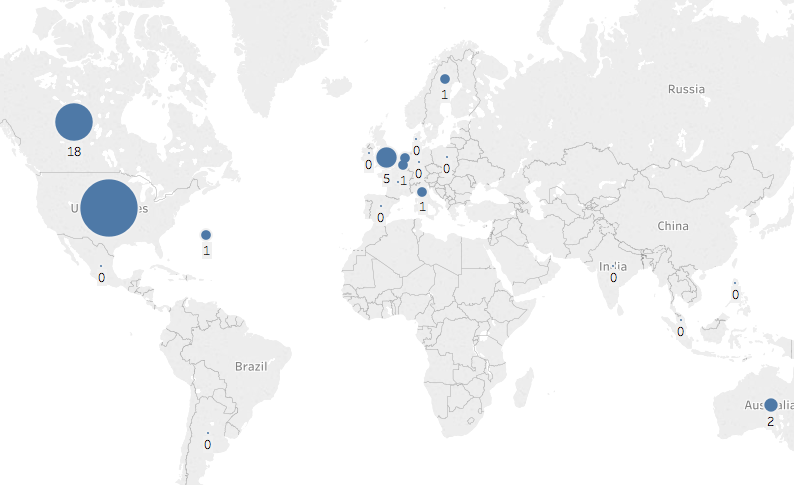

In [59]:
Image("Tablo/pic2.png") #tableau public visuals 

Following 2 graphs provide some information about country location data.

Looks like conversion rates are not really varying with respect to location. And the ones seems as if there is a corrolation in fact are outliers.

Thus even thou England seem to perform the best when it comes to conversion rates, we can not reach a very strong conclusion about its general conversion rate due to the limited data in hand.

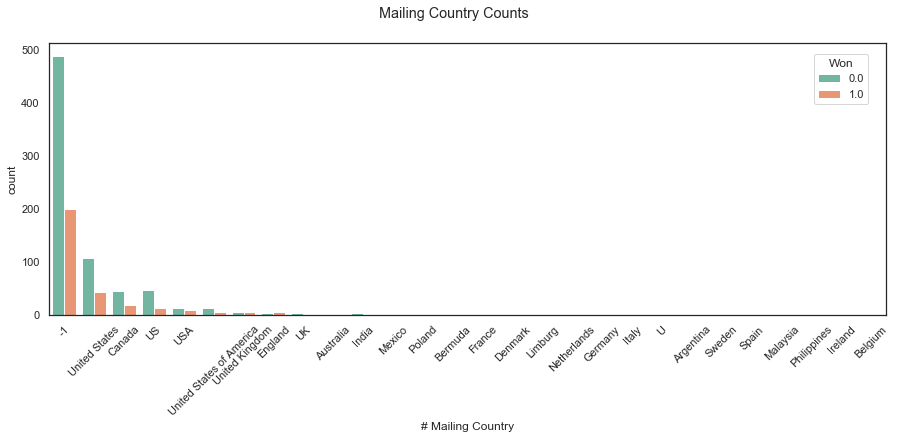

In [60]:
fun.barplot_vs(df,'Mailing Country','Won')

Similar Case here: "USA" = "US" = United States of America"

In [61]:
df['country'] = df['Mailing Country'].map(fun.country)

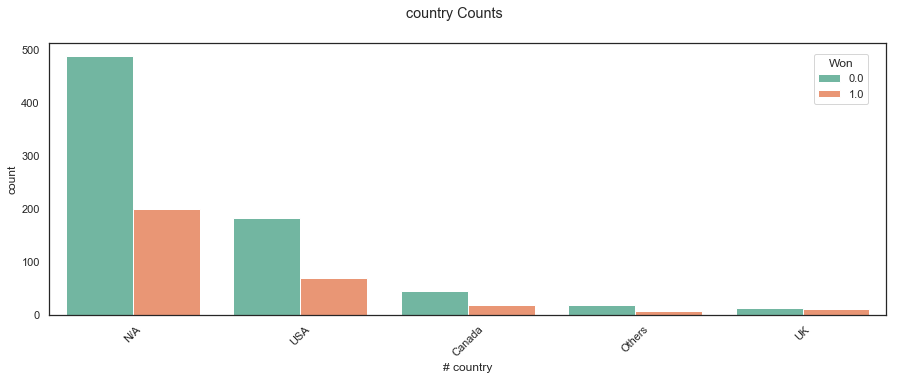

In [62]:
fun.barplot_vs(df,'country','Won')

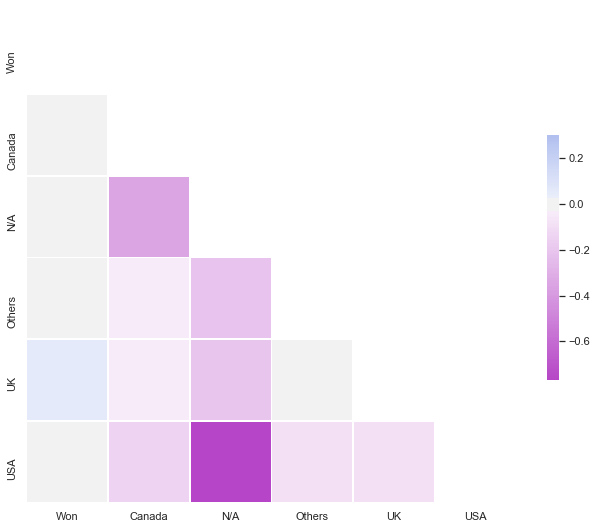

In [63]:
df_country = df[['Won','country']]
fun.heatmap(df_country,['country'])

UK performs the best. The rest do not provide any signal. However number of UK is so low that we may consider it as an outlier.

## Feature: Amount

a string? in my house? how dare?

In [64]:
type(df.Amount[0])

str

In [65]:
df.Amount[0]

'$18,000.00'

In [66]:
df['Amount'] = df.Amount.map(fun.amount_it)

In [67]:
df.Amount.describe()

count      1056.000000
mean      28461.599432
std       28893.015145
min          -1.000000
25%       18000.000000
50%       21000.000000
75%       30000.000000
max      375000.000000
Name: Amount, dtype: float64

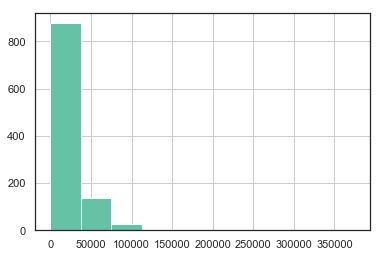

In [68]:
df.Amount.hist()

The data seems to be skewed. No machine learning model would enjoy this.

Speaking of amounts I wonder how do they change with respect to leadership ranks.

Lets have a look.

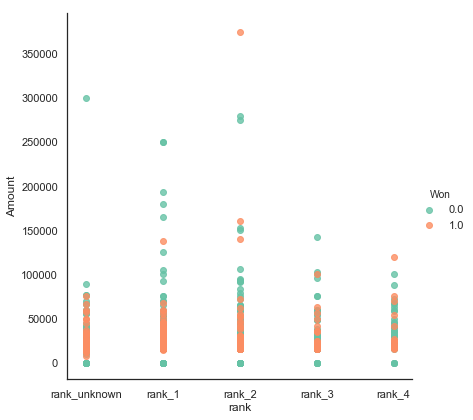

In [76]:
sns.lmplot(x='rank', y='Amount', fit_reg=False, data=df, hue='Won',size = 6)

Interesting, this is out of my expectations. I thought the higher amounts would be corrolated with the hierartical ranks.

In accordance to graphs highest amounts account for second rank leadership. 

In [80]:
df_rank = fun.one_hot_dummy(df[['rank','Amount']],['rank'])
df_rank.corr().Amount

Amount          1.000000
rank_1         -0.012925
rank_2          0.040646
rank_3         -0.021309
rank_4          0.013711
rank_unknown   -0.023423
Name: Amount, dtype: float64

rank_2 which accounts mostly for VPs is slight postitively corrolated with Amount

- unexpectedly rank_1 is negatively corrolated, I wonder what is the business case here.

**Amount Distribution**

In [81]:
def amount_groups(x):
    linspace = np.linspace(min(df.Amount),max(df.Amount)*0.8,100)
    if x >= 0:
        for i in range(len(linspace)-1):
            if x > linspace[i] and x < linspace[i+1]:
                return round(linspace[i])
            elif x > max(df.Amount)*0.8:
                return max(df.Amount)*0.8
        

    else:
        return x

In [82]:
df['Amount_group'] = df.Amount.map(amount_groups)

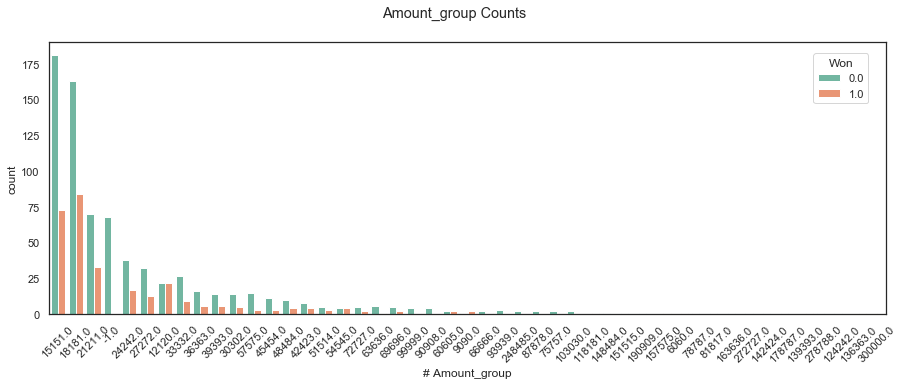

In [90]:
fun.barplot_vs(df,'Amount_group','Won')  

Interesting, looks like null Amount values never reached Won == 1.

I want to confirm that.

Winner customers(Won = 1): 0.0%
Other customers (Won = 0): 100.0%
Number of (Won = 1): 0
Number of  (Won = 0): 68


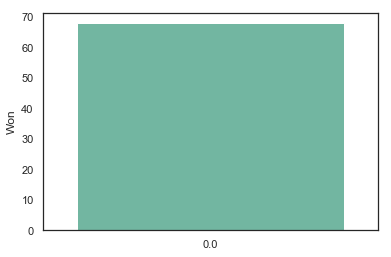

In [91]:
df_amount_null = df[df['Amount_group'] == - 1]
fun.seaborn_count_barplot_won(df_amount_null,'Won')

There are 68 null values among Amount and none of them reached success.

I assume these are simply undocumented 0s. 

In [93]:
df[(df['Amount'] == 0) & (df['Won'] == 1)].shape[0] 

0

When amount is equal to 0 won is never equal to 1. That increases my confidence in the assumption. However there can be many unknown reasons.

In [94]:
def fix_amount_nulls(x):
    if x == -1:
        return 0
    else:
        return x
df['Amount'] = df.Amount.map(fix_amount_nulls)

## Features: TIME: Close_Date and Created_Date

Reminder: Time information have no, null values.

Data Type:

In [96]:
print(df['Close Date'][0])
print(type(df['Close Date'][0]))

11/5/2018
<class 'str'>


Changes

In [98]:
df['Close_Date'] = pd.to_datetime(df['Close Date'])
df['Created_Date'] = pd.to_datetime(df['Created Date'])

print(df['Close_Date'][0])
print(type(df['Close_Date'][0]))

2018-11-05 00:00:00
<class 'pandas._libs.tslib.Timestamp'>


What year is this?!

In [99]:
df.Close_Date.dt.year.unique()

array([2018, 2017])

In [100]:
df.Created_Date.dt.year.unique()

array([2018, 2017, 2016])

Some accounts created as early as 2016 and I want to see if there is a behavioral difference in accordance to years.

In [102]:
df['close_year'] = df.Close_Date.dt.year
df['create_year'] = df.Created_Date.dt.year

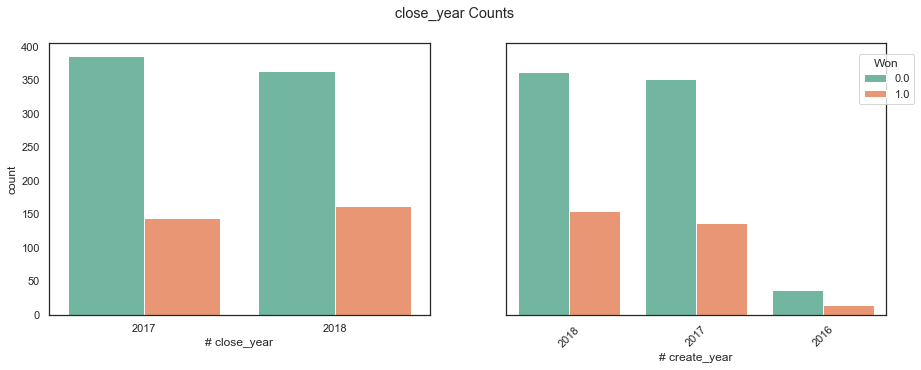

In [103]:
fun.barplot_double_vs(df,'close_year','create_year','Won')

- Accounts that are closed by 2018 had higher chances of Won == 2018 compared to those of 2017.
- Accounts that are created in 2016 had slightly higher probability of Won == 1

**New Feature: Registered days = Close_Date - Created_Date**

Number of registered days for each account:

In [104]:
df['Registered_Days'] = df['Close_Date'] - df['Created_Date']

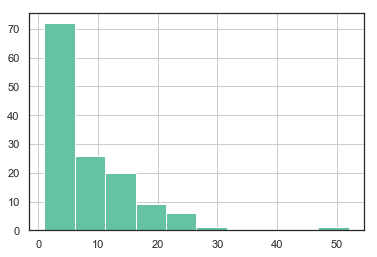

In [105]:
df['Registered_Days'].value_counts().hist()

In [106]:
type(df['Registered_Days'][0]) #not you little one. You can not be a timedelta.

pandas._libs.tslib.Timedelta

In [107]:
df['Registered_Days'] = df['Registered_Days'].dt.days
type(df['Registered_Days'][0]) # gotcha!

numpy.int64

In [111]:
df[['Registered_Days']].describe() # that explains the skewness.

,Registered_Days
count,1056.000000
mean,39.454545
std,36.257005
min,-40.000000
25%,10.000000
50%,31.000000
75%,61.000000
max,259.000000


In [112]:
df[['Amount','Registered_Days','Won']].corr() # are you usefull?

,Amount,Registered_Days,Won
Amount,1.000000,-0.011173,-0.008167
Registered_Days,-0.011173,1.000000,-0.339557
Won,-0.008167,-0.339557,1.000000


Negative 0.34 pearson corrolation. You are usefull unlike Amount.

Did you notice that min: - 40 ? I wonder how an organization can close an account before opening it.

Shall we get rid of those **abnormal registered days?**

In [113]:
(df['Registered_Days'] < 0).sum()

11

They are small in numbers and the ratio (1% of all data accounts for abnormal registered days)

In [114]:
df[df['Registered_Days'] < 0].Registered_Days.value_counts()

-3     3
-1     3
-5     2
-25    1
-40    1
-4     1
Name: Registered_Days, dtype: int64

I will get rid of abnormal registered days, only if its Win Rates are alligned with the rest of the dataset.

In [116]:
df_anormal_register = df[df['Registered_Days'] < 0]

Winner customers(Won = 1): 81.8%
Other customers (Won = 0): 18.2%
Number of (Won = 1): 9
Number of  (Won = 0): 2


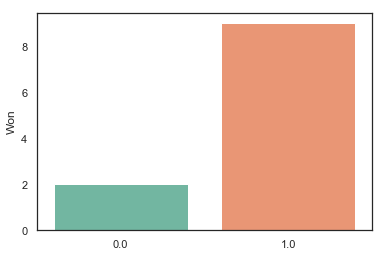

In [117]:
fun.seaborn_count_barplot_won(df_anormal_register,'Won')

Interesting! The winrate among data points that present abnormal registered days is dramatically higher compared to historical 29%.

In case these abnormal day counts would be higher in numbers I would create a new binarized feature such as "abnormal_r_days". However in accordance to the fact that these datapoints account for only 1% of the complete data set will lead to unbalanced data issues. In addition I don't want to drop these. Consequently I will replace these values with the minimum positive or the average of the number of registered days.

In [118]:
print(df[df.Registered_Days > 0].Registered_Days.mean())
print(df[df.Registered_Days > 0].Registered_Days.median())
print(df[df.Registered_Days > 0].Registered_Days.min())

42.04934541792548
37.0
1


Lets go with the median. Why? I don't know since I am not informed about the business case or any information regarding the given data.

In [119]:
def fix_registered_days(x):
    if x < 0:
        return df[df.Registered_Days > 0].Registered_Days.median()
    else:
        return x
df['Registered_Days'] = df['Registered_Days'].map(fix_registered_days)

What can I learn from the change of amount in accordance to close date of accounts?

I decided to concentrate my analisis on close dates because that is when it is decided when Won reached a result.

In [120]:
df_close = df.drop(['Created_Date'],axis = 1)

In [121]:
df_close.close_year.value_counts().sum()

1056

In [122]:
df_close.shape

(1056, 23)

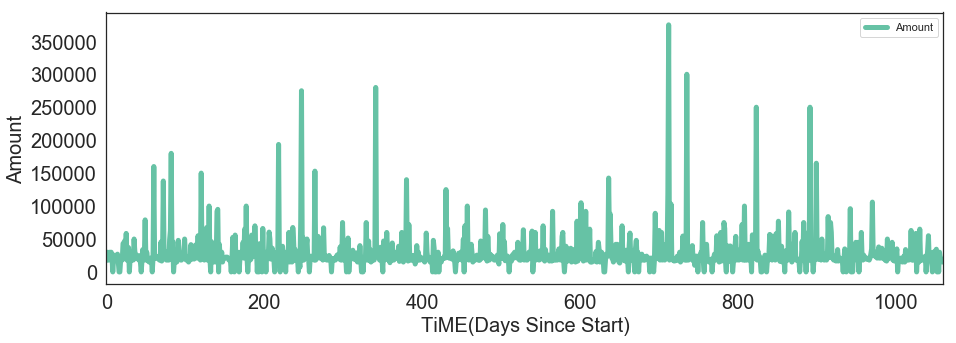

In [124]:
df_close[['Amount']].plot(figsize=(15,5), linewidth=5, fontsize=20)
# df_create[['Amount_test']].plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.ylabel('Amount', fontsize=20);
plt.xlabel('TiME(Days Since Start)', fontsize=20);

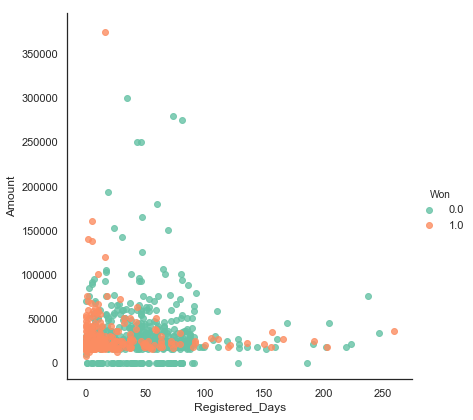

In [125]:
sns.lmplot(x='Registered_Days', y='Amount', fit_reg=False, data=df, hue='Won',size = 6)

I wonder what is the story behind that $ 350000

- Most accounts led to Won == 1 did not wait more than 100 days
- The WR for account owners that wait longer is higher.

526
162
530
144
0.1534090909090909% of attendies Won in 2018
0.13636363636363635% of attendies Won in 2017


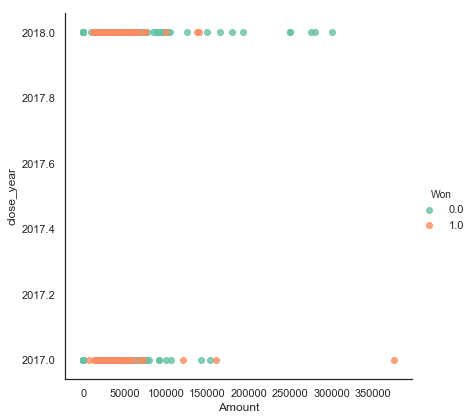

In [126]:
sns.lmplot(x='Amount', y='close_year', fit_reg=False, data=df_close, hue='Won',size = 6);
print((df_close.close_year == 2018).sum())
print(((df_close.close_year == 2018) & (df.Won == 1) ).sum())
print((df_close.close_year==2017).sum())
print(((df_close.close_year == 2017) & (df.Won == 1) ).sum())
print(f'{((df_close.close_year == 2018) & (df.Won == 1) ).sum() / df.shape[0]}% of attendies Won in 2018')
print(f'{((df_close.close_year == 2017) & (df.Won == 1)).sum() / df.shape[0]}% of attendies Won in 2017')

Oh thats an increase! How about the Won amounts?

In addition to slightly increased WR, number of accounts which invested/played higher amonts of money increased.

**Assumption:**  See that single outlier which is Won == 1 and amount > $ 350k at the year 2017.

My intuation tells me that, it is kind of a customized value for marketing purposes. 2017 was the first year that there was a conclusion about Won. And the prize, for the first trial shall be significant in order to leverage outcomes of marketing and sales. Who knows, maybe increased amounts of finances for the second year is due to the fact that people heard "Someone won $ 350k!".


### Total Amount Won and Invested for 2017 and 2018


## 2018

won_amount_2018: $4446500
non_won_amount_2018: $11712730
amount_total_2018: $16159230


won_2018: 15.0%


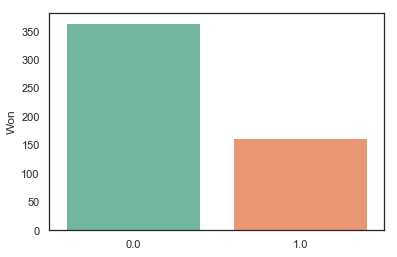

In [127]:


won_amount_2018 = df_close[(df_close.close_year == 2018) & (df_close.Won == 1)].Amount.sum()
non_won_amount_2018 = df_close[(df_close.close_year == 2018) & (df_close.Won == 0)].Amount.sum()
amount_total_2018 = won_amount_2018 + non_won_amount_2018



df_close_2018 = df_close[df_close.close_year == 2018]
counts = df_close_2018['Won'].value_counts()
sns.barplot(counts.index, counts);

print(f"won_amount_2018: ${won_amount_2018}")
print(f"non_won_amount_2018: ${non_won_amount_2018}")
print(f"amount_total_2018: ${amount_total_2018}")
print('\n')
print(f"won_2018: {round(df_close_2018.Won.sum()/df_close.shape[0],2)*100}%")

## 2017

won_amount_2017: $4149785
non_won_amount_2017: $9746500
amount_total_2017: $13896285


won_2017: 14.000000000000002%


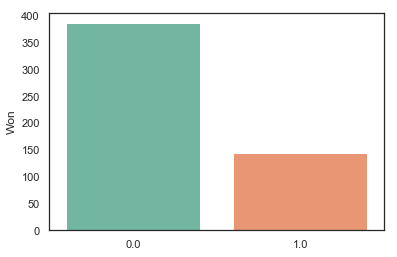

In [128]:
won_amount_2017 = df_close[(df_close.close_year == 2017) & (df_close.Won == 1)].Amount.sum()
non_won_amount_2017 = df_close[(df_close.close_year == 2017) & (df_close.Won == 0)].Amount.sum()
amount_total_2017 = won_amount_2017 + non_won_amount_2017



df_close_2017 = df_close[df_close.close_year == 2017]
counts = df_close_2017['Won'].value_counts()
sns.barplot(counts.index, counts);

print(f"won_amount_2017: ${won_amount_2017}")
print(f"non_won_amount_2017: ${non_won_amount_2017}")
print(f"amount_total_2017: ${amount_total_2017}")
print('\n')
print(f"won_2017: {round(df_close_2017.Won.sum()/df_close.shape[0],2)*100}%")

## Difference

In [129]:
Amount_won_diff = won_amount_2018 - won_amount_2017
Amount_non_won_diff = non_won_amount_2018 - non_won_amount_2017
amount_total_diff = amount_total_2018  - amount_total_2017

increase = amount_total_diff / amount_total_2017

print(f"Amount_won_diff: ${Amount_won_diff}")
print(f"Amount_won_diff_ratio: {round((Amount_won_diff / won_amount_2017) * 100,2)}%")
print("---------------------------------")
print(f"Amount_non_won_diff: ${Amount_non_won_diff}")
print(f"amount_total_diff: ${amount_total_diff}")
print(f"increase: {round(increase*100,2)}% from 2017 to 2018")

Amount_won_diff: $296715
Amount_won_diff_ratio: 7.15%
---------------------------------
Amount_non_won_diff: $1966230
amount_total_diff: $2262945
increase: 16.28% from 2017 to 2018


### New Feature: Time: Day

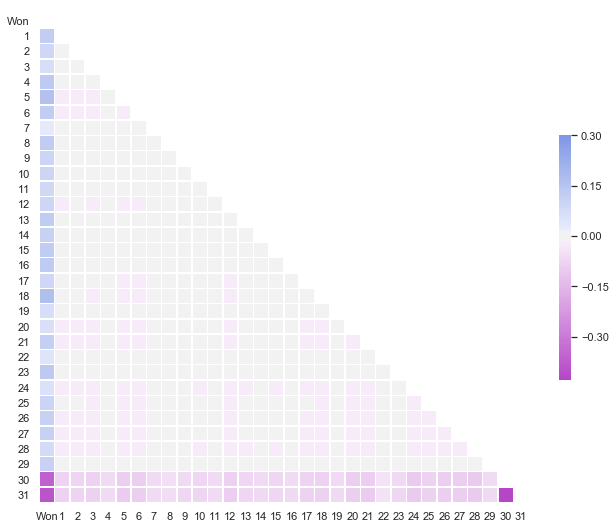

In [130]:
df['day'] = df.Close_Date.dt.day
df_day = df[['Won','day']]
fun.heatmap(df_day,['day'])

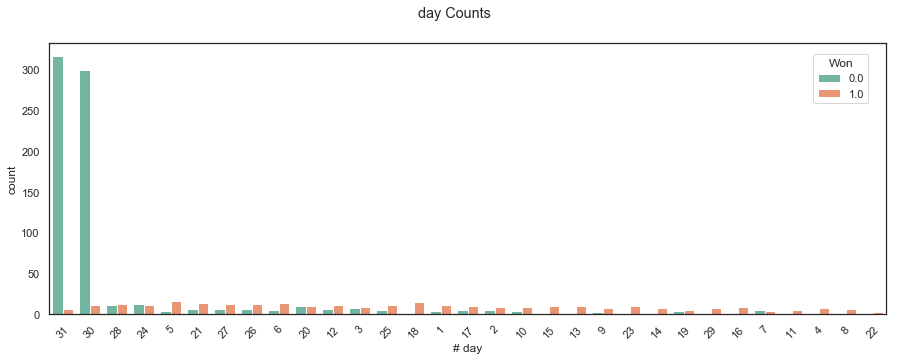

In [131]:
fun.barplot_vs(df_day,'day','Won')

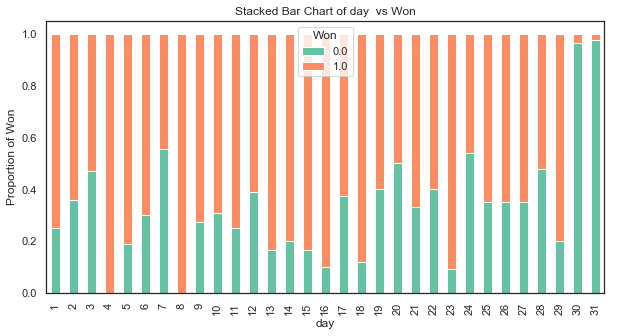

In [132]:
fun.stacked_bar_chart(df_day,'day','Won')  #remember most of the following subcategories are very low in numbers.

- That's exciting. The number of closed accounts are significantly more for the end of the month compared to the rest.

- In additoon, for most of the days that the acconts are closed conversion rates are above 50%. The signal may be strong with this one.

**Assumption**: Maybe this organization closes the accounts at the end of the month regardless of success or failure.

### New Feature: Time : Weeks

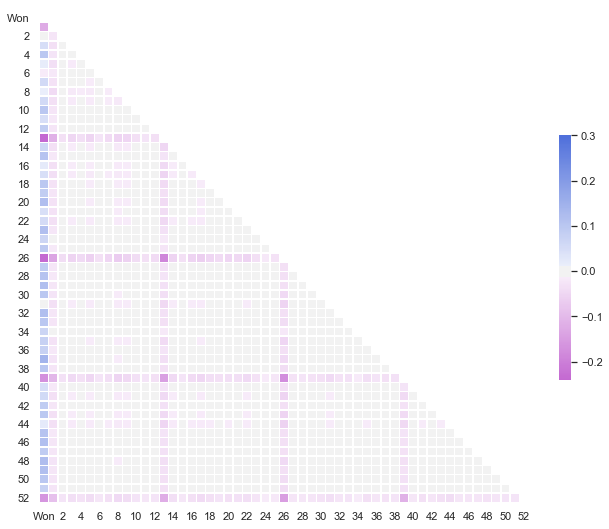

In [133]:
df['week'] = df.Close_Date.dt.week
df_week = df[['Won','week']]
fun.heatmap(df_week,['week'])

There is certainly a repeatable pattern here. My intuition tells me that these are quarters of the year. 

I want to see if the pattern is relevant for months as well.

## New Feature: Time: Month

In [134]:
df['month'] = df.Close_Date.dt.month
df_months = df[['Won','month']]

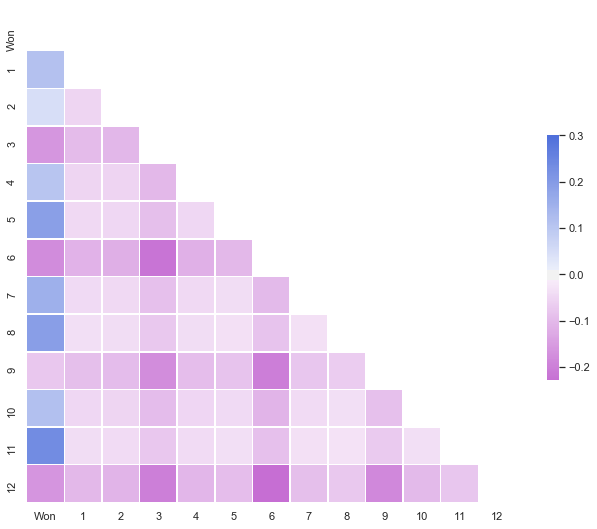

In [135]:
fun.heatmap(df_months,['month'])

- Strong positively correlated months with Won: November, August, May
- Weak positively correlated months with Won: April, July, October, Jan
- Negatively correlated months with Won: March, June, December

Noticed an interesting pattern? Check the month couples April: May, July: Aug, October: November

- Somehow within each month couple, the first month warmed up the correlations and in the second-month correlations peaked.
- Moreover, as if the business is resting or waters are calming at the following third month, correlations are negative. A pattern which repeats itself for 3 times given 12 correlations. That cannot happen by pure luck.

I really wonder the nature of the business case here.

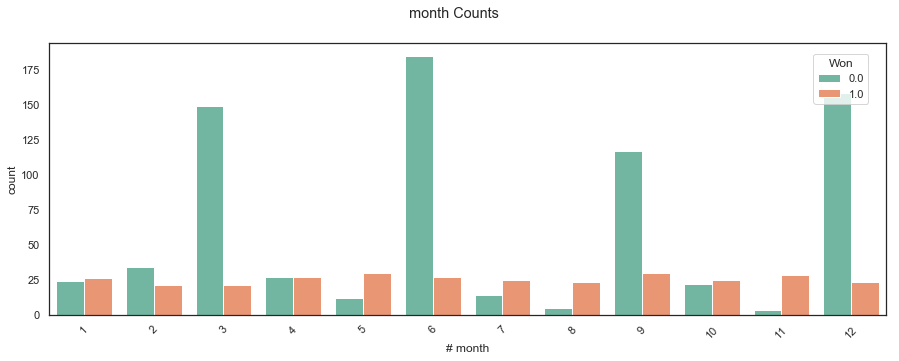

In [138]:
fun.barplot_vs_test(df_months,'month','Won')

- Looks like the standard deviation for the number of Won == 1 through the months is a low number. The number of winners seems to be constant within a limited space.
- On the other hand, the WR varies a lot. Compare that win rate for the 6th month with 11th.

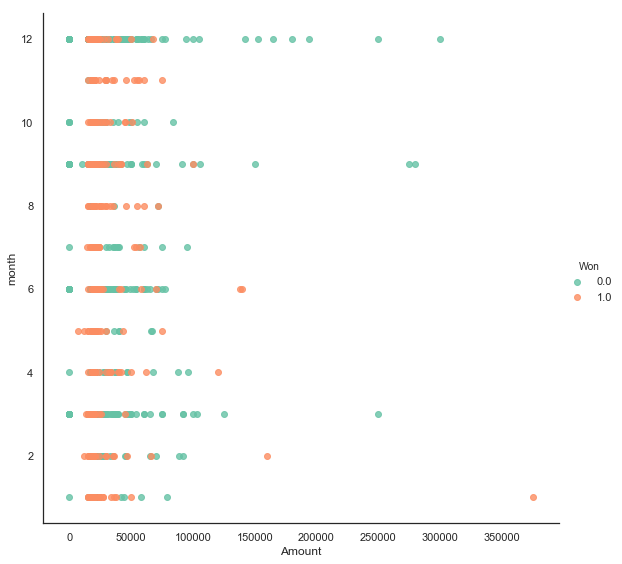

In [141]:
sns.lmplot(x='Amount', y='month', fit_reg=False, data=df, hue='Won',size = 8);

- I am more confident about my assumption which states that the initial $ 350k+ is customized in order to leverage marketing & sales which will populate the pipeline with more accounts.

How come?

- We know that 350k Won ==1 accounts for 2017 which is the first year of any Closed_date. Now we also know that the same amount accounts for the first month of 2017.

What are the odds? The highest amount offering succeeded through the first month of the first year possible year. Following year the pipeline becomes more crowded. Good story.

Unless this is a company that initiated its operations with a marquee customer. 

There is one more question in my mind: Can we build a binary classifier predictive model to find out which accounts lead to Won == 1?

Of course, we can.
- Found all the correlations
- Created subcategories and new features
- The target is balanced
- Good vibes are real, deep house music is with me.
- Looks like we have everything we need to build that model.

In [142]:
drop_list = ['Account Name','Contact: Title','Industry','Close Date','Created Date',
             'mktg','google','Close_Date','Created_Date','Amount_group','Mailing City', 'Mailing State/Province',
            'Mailing Country']
df_save = df.drop(drop_list, axis = 1)

In [143]:
df_save.columns

Index(['Lead Source', 'Amount', 'Won', 'rank', 'job_category', 'lead_group',
       'industry_groups', 'country', 'close_year', 'create_year',
       'Registered_Days', 'day', 'week', 'month'],
      dtype='object')

In [144]:
df_save.corr()

,Amount,Won,close_year,create_year,Registered_Days,day,week,month
Amount,1.000000,-0.008167,0.077937,0.051952,-0.011018,0.004433,-0.068509,0.050713
Won,-0.008167,1.000000,0.039993,0.021259,-0.326850,-0.593526,0.058956,-0.038386
close_year,0.077937,0.039993,1.000000,0.921079,-0.041171,0.064994,-0.169464,0.037617
create_year,0.051952,0.021259,0.921079,1.000000,-0.200702,0.155243,-0.021121,0.172215
Registered_Days,-0.011018,-0.326850,-0.041171,-0.200702,1.000000,0.157750,-0.045000,0.013661
day,0.004433,-0.593526,0.064994,0.155243,0.157750,1.000000,0.078100,0.155264
week,-0.068509,0.058956,-0.169464,-0.021121,-0.045000,0.078100,1.000000,0.669897
month,0.050713,-0.038386,0.037617,0.172215,0.013661,0.155264,0.669897,1.000000


before going through the model notes:


# Hey Kids, wana see some ART?

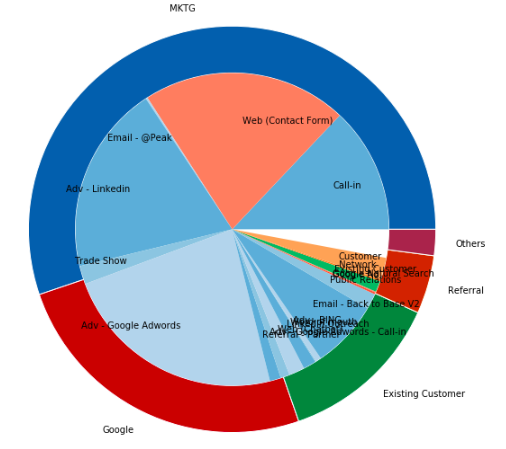

In [146]:
Image("Tablo/pain.png")  
#the ancients call it: "good effort"
#Other data scientists call it: "What is wrong with you?"

You see, time is continious, ongoing and unstopable. Like a blue longlasting wave. 

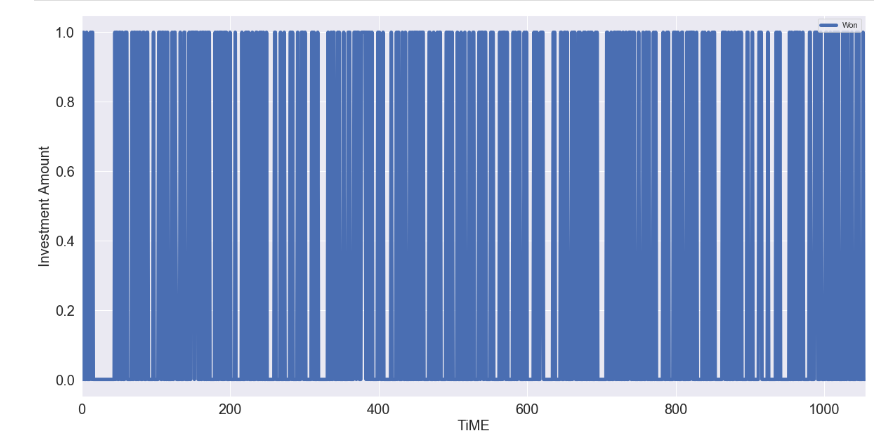

In [147]:
Image("Tablo/blue_waves.png")

Look at all of those beautiful colours! Most meaningful visulization ever? Experts have doubts.

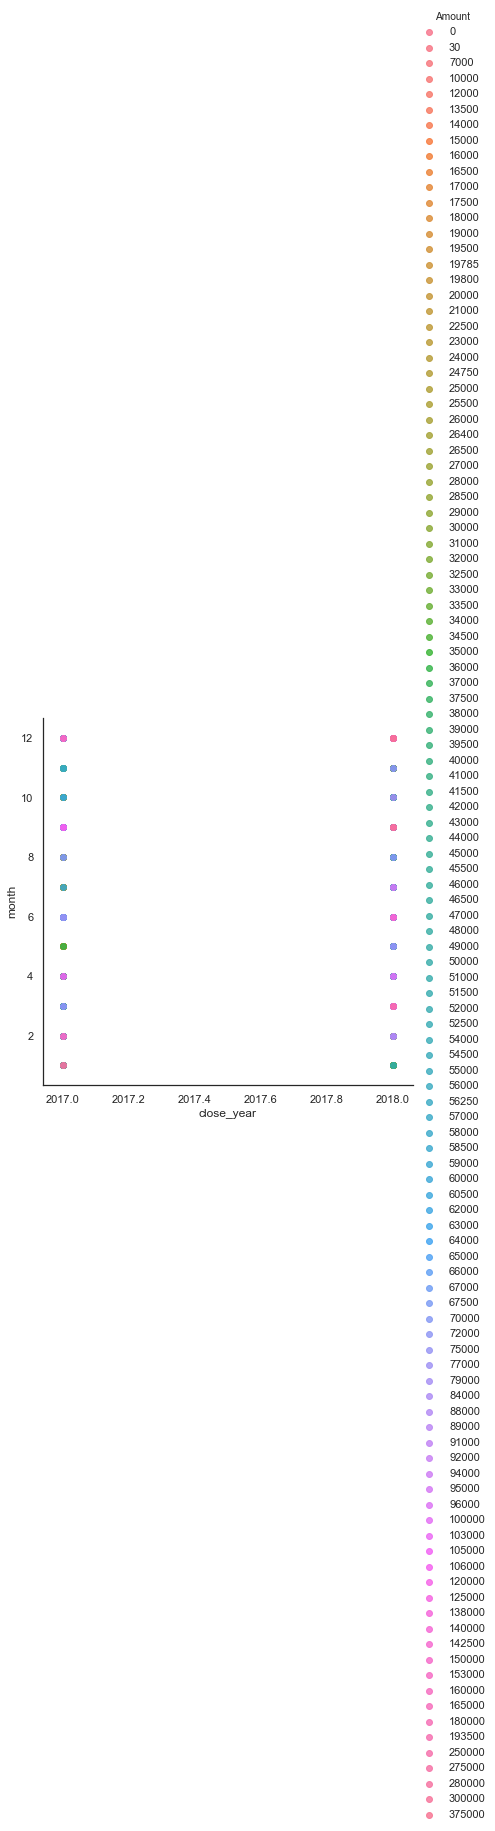

In [148]:
sns.lmplot(x='close_year', y='month', fit_reg=False, data=df, hue='Amount',size = 6);